In [1]:
!sudo uv pip install --system pygmid

Resolved 21 packages in 2.82s                                        
Building ply==3.105)                                                   
Building ply==3.10                                             
⠙ Preparing packages... (0/5)
Building ply==3.10------     0 B/24.61 kB                      
⠙ Preparing packages... (0/5)
Building ply==3.10------ 1.38 kB/24.61 kB                      
⠙ Preparing packages... (0/5)
Building ply==3.10------ 4.13 kB/24.61 kB                      
⠙ Preparing packages... (0/5)
Building ply==3.10------ 8.27 kB/24.61 kB                      
⠙ Preparing packages... (0/5)
Building ply==3.10------ 12.40 kB/24.61 kB                     
⠙ Preparing packages... (0/5)
Building ply==3.10------ 17.76 kB/24.61 kB                     
⠙ Preparing packages... (0/5)
Building ply==3.10--- 21.90 kB/24.61 kB                     
⠙ Preparing packages... (0/5)
Building ply==3.10-- 24.61 kB/24.61 kB                     
Building ply==3.10                               

In [339]:
from pygmid import Lookup as lk
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matfile = Path("web_matlab/lib/65nch.mat")
matfile = Path("simulations/nfet_01v8_lvt.mat")

if not matfile.exists():
    raise ValueError("MAT file doesn't exists")

data=lk(filename=str(matfile))

# Example
params={
    "L": 0.15, # Min length on sky130
    "VGS": 0.9,
    "VDS": 0.9, # Se asume V_max/2
    "VSB": 0, # source to VSS as usual on NMOS
}

print(f"Transconductance      {data.look_up('GM', **params):.2e}")
print(f"Output conductance    {data.look_up('GDS', **params):.2e}")
print(f"Transconductance Eff  {data.look_up('GM_ID', **params):.2e}")
print(f"Angular transit freq  {data.look_up('GM_CGG', **params):.2e}")
print(f"Intrinsic Gain        {data.look_up('GM_GDS', **params):.2e}")

Transconductance      2.26e-03
Output conductance    1.60e-04
Transconductance Eff  4.81e+00
Angular transit freq  3.70e+11
Intrinsic Gain        1.42e+01


/tmp/ipykernel_11886/2804257299.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(data["VGS"])) # GM_ID plot


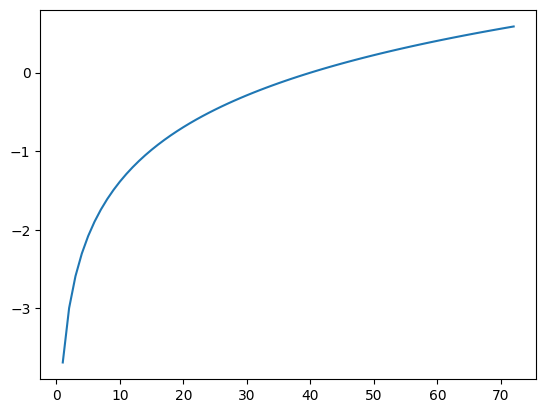

In [54]:
# Example
params={
    "L": 0.15, # Min length on sky130
    "VDS": 0.9,
    "VSB": 0, # source to VSS as usual on NMOS
}

# plt.plot(data.look_up("ID", **params)) # ID Current
# plt.plot(np.log(data.look_up("ID", **params))) # Log of ID, shows drift + diff
# plt.plot(np.log(data.look_up("GM_ID", **params))) # GM_ID plot

## Comparativa entre figuras de mérito (sobre $V_{GS}$)

El siguiente gráfico compara la eficiencia de gm con la frecuencia tránsito del transistor.
Se utiliza el voltaje de compuerta en eje X, por lo que aún se puede visualizar $V_{OV}$ en el.

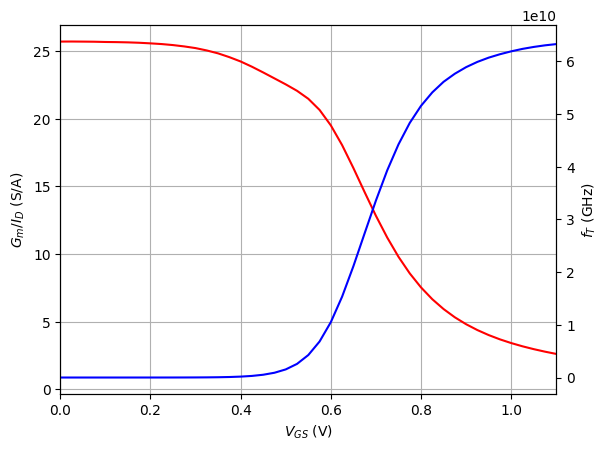

In [63]:
params={
    "L": 0.15, # Min length on sky130
    "VDS": 0.9,
    "VSB": 0, # source to VSS as usual on NMOS
}

fig, ax1 = plt.subplots()
ax2=ax1.twinx()

#x = data.look_upVGS(**params)
ax1.set_xlabel("$V_{GS}$ (V)")
ax1.set_xlim(0, 1.1)

ax1.set_ylabel("$G_m/I_D$ (S/A)")
ax1.plot(
    data["VGS"],
    data.look_up("GM_ID", **params),
    color="r"
)
ax2.set_ylabel("$f_T$ (GHz)")
ax2.plot(
    data["VGS"],
    data.look_up("GM_CGG", **params)*1/(2*np.pi),
    color="b"
) # ID Current

ax1.grid()
plt.show()

## Diseñar sin $V_{OV}$

Es posible diseñar ignorando $V_{OV}$.
Así se visualiza directamente el tradeoff entre cualquier figura de mérito y $\frac{G_m}{I_D}$

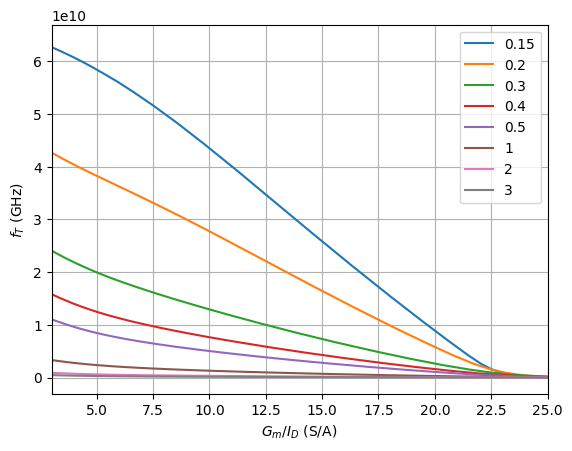

In [84]:
fig, ax = plt.subplots()

ax.set_xlabel("$G_{m}/I_{D}$ (S/A)")
ax.set_xlim(3, 25)

#for L in data["L"]:
for L in [0.15, 0.2, 0.3, 0.4, 0.5, 1, 2, 3]:
    params={
        "L": L,
        "VDS": 0.9,
        "VSB": 0, # source to VSS as usual on NMOS
    }

    ax.set_ylabel("$f_T$ (GHz)")
    ax.plot(
        data.look_up("GM_ID", **params),
        data.look_up("GM_CGG", **params)*1/(2*np.pi),
        label=L
    ) # ID Current

ax.grid()
ax.legend()
plt.show()

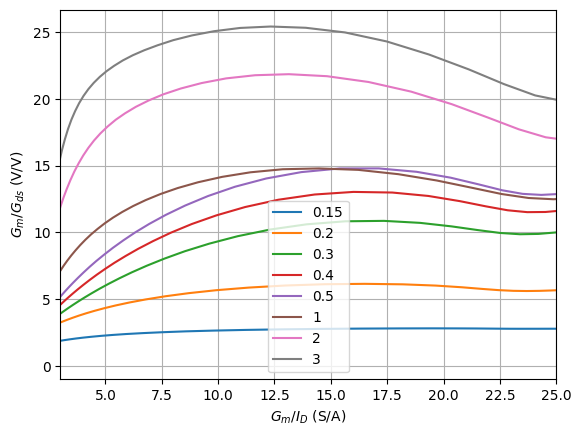

In [249]:
fig, ax = plt.subplots()

ax.set_xlabel("$G_{m}/I_{D}$ (S/A)")
ax.set_xlim(3, 25)

#for L in data["L"]:
for L in [0.15, 0.2, 0.3, 0.4, 0.5, 1, 2, 3]:
    params={
        "L": L,
        "VDS": 0.9,
        "VSB": 0, # source to VSS as usual on NMOS
    }

    ax.set_ylabel("$G_m/G_{ds}$ (V/V)")
    ax.plot(
        data.look_up("GM_ID", **params),
        data.look_up("GM_GDS", **params)*1/(2*np.pi),
        label=L
    ) # ID Current

ax.grid()
ax.legend()
plt.show()

## Sobre $V_{Dsat}$

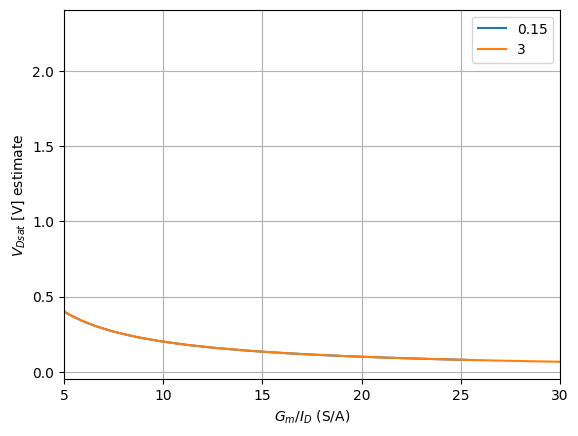

In [81]:
fig, ax = plt.subplots()

ax.set_xlabel("$G_{m}/I_{D}$ (S/A)")
ax.set_xlim(5, 30)

for L in [0.15, 3]:
    params={
        "L": L,
        "VDS": 0.9,
        "VSB": 0, # source to VSS as usual on NMOS
    }

    ax.set_ylabel("$V_{Dsat}$ [V] estimate")
    ax.plot(
        data.look_up("GM_ID", **params),
        2/data.look_up("GM_ID", **params),
        label=L
    ) # ID Current

ax.grid()
ax.legend()
plt.show()

## Flujo de diseño básico

Lo usual:

1. En base a especificaciones, determinar $g_m$
    1. Si no se puede determinar, habrá que ser creativo.
1. Escoger L.
    1. Canal corto => Alta velocidad $f_T$
    1. Canal largo => Alta ganancia intrínseca
1. Escoger $g_m/I_D$
    1. Grande  => Baja corriente, large signal swing, bajo $V_{Dsat}$
    1. Pequeño => Alta velocidad $f_T$
1. Calcular $I_D$ con $g_m$
1. Calcular W con densidad de corriente $J_D=I_D/W$

## Dimensionamiento de par diferencial

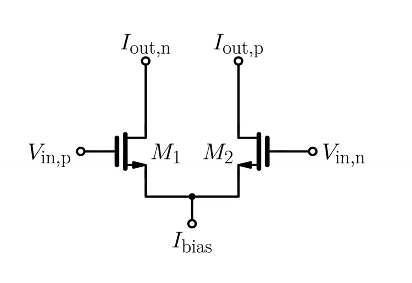

Requerimientos:

- $g_m = 10$ mS
- $L=0.15 $ um
- Evaluar para $g_m/I_D=6$ y $20$ S/A
- Obtener $W$ e $I_D$
- Estimar $C_{gg}$ y $f_T$

In [337]:
import pandas as pd

def size_diff_pair(data, gm_id):
    params = {
        "gm_id": gm_id,
        "l": 0.15, # um
        "vsb": 0, # V
        "vds": 0.9, # V. Centrar el punto de operación del par diferencial
    }

    # Fixed parameters
    ##################

    gm = 10e-3 # S

    # Obtained from tables
    ######################

    id_w = data.look_up("id_w", **params)
    # Which one should I use?
    cgg_w = data.look_up("cgg_w", **params)
    gm_cgg = data.look_up("gm_cgg", **params)

    # Calculated
    ############

    id = gm / gm_id # A
    w = id / id_w

    # Which one is better?
    cgg = cgg_w * w
    cgg = gm / gm_cgg

    ft = gm_cgg / (2 * np.pi)

    # gm_id [S/A]
    # id    [A]
    # w     [um]
    # cgg   [V/V]
    # ft    [Hz]

    return pd.DataFrame.from_dict(
        data={
            **params,
            "gm_id":   gm_id,
            "id":   id,
            "w":  w,
            "cgg": cgg,
            "ft": ft,
        },
        orient="index"
    )

df = pd.DataFrame()

df["gm/ID=6"] = gmid_6 = size_diff_pair(data, 6)
df["gm/ID=20"] = gmid_20 = size_diff_pair(data, 20)

print(df)

df["comparison"] = df["gm/ID=6"] / df["gm/ID=20"]
df["comparison"]

            gm/ID=6      gm/ID=20
gm_id  6.000000e+00  2.000000e+01
l      1.500000e-01  1.500000e-01
vsb    0.000000e+00  0.000000e+00
vds    9.000000e-01  9.000000e-01
id     1.666667e-03  5.000000e-04
w      2.347374e+01  1.624752e+02
cgg    2.845087e-14  1.790108e-13
ft     5.594027e+10  8.890802e+09


gm_id    0.300000
l        1.000000
vsb           NaN
vds      1.000000
id       3.333333
w        0.144476
cgg      0.158934
ft       6.291927
Name: comparison, dtype: float64

## Problemas en los PDKs




### 1. Capacitancias overlap no se muestran

En Sky130, solo se definen 16 capacitancias que vienen de una matriz de transcapacitancia 4x4, no tomando en consideración las capacitancias de overlap del transistor. PDKs como IHP si tienen esto en consideración.

Sin embargo, estas capacitancias si se consideran durante la simulación. Simplemente no se muestran en la salida.

Boris agrega estas capacitancias manualmente en los archivos `.mat`, pero solamente las de nmos hacen sentido. Las de pmos no.

$C_{fringe}$

### 2.

Caracterización de pfets entrega una curva gm/id erronea, por lo que los modelos no se pueden ocupar para diseño en inversión débil o moderada.

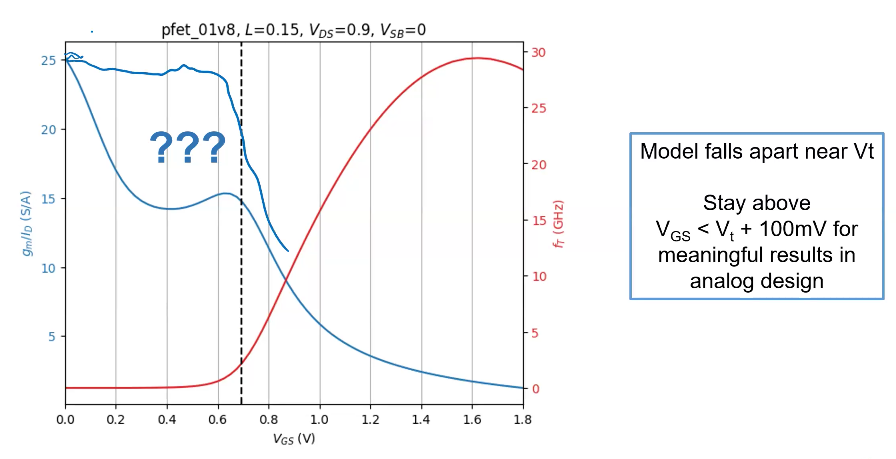

Obs, pfet lvt está restringido a canales más largos.

## Mejorando función de gmid

In [377]:
def gmid_basic_workflow(fet_model, mos_params):
    gm_id = mos_params["gm_id"]
    gm = mos_params["gm"]

    # Obtained from tables
    ######################

    id_w = fet_model.look_up("id_w", **mos_params)
    # Which one should I use?
    # cgg_w = fet_model.look_up("cgg_w", **mos_params)
    gm_cgg = fet_model.look_up("gm_cgg", **mos_params)

    # Calculated
    ############

    id = gm / gm_id # A
    w = id / id_w

    # Which one is better?
    # cgg = cgg_w * w
    cgg = gm / gm_cgg

    ft = gm_cgg / (2 * np.pi)

    # gm_id [S/A]
    # id    [A]
    # w     [um]
    # cgg   [V/V]
    # ft    [Hz]

    return pd.DataFrame.from_dict(
        data={
            **mos_params,
            "gm_id":   gm_id,
            "id":   id,
            "w":  w,
            "cgg": cgg,
            "ft": ft,
        },
        orient="index"
    )

matfile = Path("simulations/nfet_01v8_lvt.mat")

if not matfile.exists():
    raise ValueError("MAT file doesn't exists")


nfet_01v8_lvt = lk(filename=str(matfile))

mos_params = {
    "gm_id": 6, # S/A
    "gm": 10e-3, # S
    "l": 0.15, # um
    "vsb": 0, # V
    "vds": 0.9, # V. Centrar el punto de operación del par diferencial
}

df = pd.DataFrame()

for gm_id in [5, 8, 11, 14, 17, 20]:
    mos_params["gm_id"] = gm_id
    df[f"gm/ID={gm_id}"]  = gmid_basic_workflow(nfet_01v8_lvt, mos_params)

print(df)

# df["comparison"] = df["gm/ID=5"] / df["gm/ID=20"]
# df["comparison"]

            gm/ID=5       gm/ID=8      gm/ID=11      gm/ID=14      gm/ID=17  \
gm_id  5.000000e+00  8.000000e+00  1.100000e+01  1.400000e+01  1.700000e+01   
gm     1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02   
l      1.500000e-01  1.500000e-01  1.500000e-01  1.500000e-01  1.500000e-01   
vsb    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
vds    9.000000e-01  9.000000e-01  9.000000e-01  9.000000e-01  9.000000e-01   
id     2.000000e-03  1.250000e-03  9.090909e-04  7.142857e-04  5.882353e-04   
w      2.229146e+01  2.655612e+01  3.381895e+01  4.690411e+01  7.437676e+01   
cgg    2.722954e-14  3.175650e-14  3.971982e-14  5.415788e-14  8.425007e-14   
ft     5.844937e+10  5.011728e+10  4.006940e+10  2.938722e+10  1.889078e+10   

           gm/ID=20  
gm_id  2.000000e+01  
gm     1.000000e-02  
l      1.500000e-01  
vsb    0.000000e+00  
vds    9.000000e-01  
id     5.000000e-04  
w      1.624752e+02  
cgg    1.790108e-13  
ft     8.89

/tmp/ipykernel_11886/3036006771.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_11886/3036006771.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


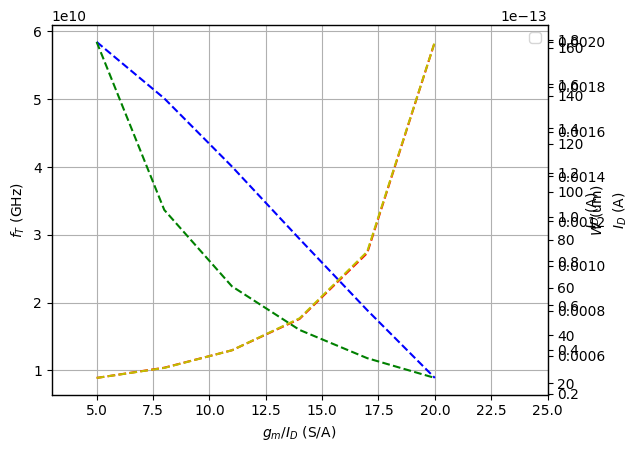

In [425]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.set_xlabel("$g_{m}/I_{D}$ (S/A)")
ax1.set_xlim(3, 25)


ax1.set_ylabel("$f_T$ (GHz)")
ax1.plot(
    df.loc["gm_id"].values,
    df.loc["ft"].values,
    "b--"
)

ax2.set_ylabel("$W$ (um)")
ax2.plot(
    df.loc["gm_id"].values,
    df.loc["w"].values,
    "r--"
)

ax3.set_ylabel("$I_D$ (A)")
ax3.plot(
    df.loc["gm_id"].values,
    df.loc["id"].values,
    "g--"
)

ax4.set_ylabel("$I_D$ (A)")
ax4.plot(
    df.loc["gm_id"].values,
    df.loc["cgg"].values,
    "y--"
)

ax1.grid()
ax1.legend()
fig.show()

#df.loc["id"].values